# THESIS: GPR FORMULARS

by Sebastian T. Glavind, May, 2020


In [10]:
import numpy as np
import math
import GPy
import scipy.stats as ss
import scipy.special as ssp
import seaborn as sns
import pandas as pd
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

## Sample data

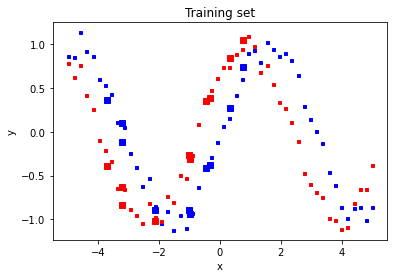

In [11]:
np.random.seed(42)
# Noise free/Noisy training data
nX_tr = 10
std_y = 1e-1 # if noise free set to 1e-4 for numerical stability; corr. var = 1e-16 addition along diagonal
XX = np.random.uniform(low=-4, high=1, size=(nX_tr,1)).reshape(-1,1)
YY = np.concatenate((np.sin(XX), np.sin(XX+np.pi/4)), axis=1) + std_y*np.random.normal(size=(nX_tr,1))

# Test data
nX_te = 50
XX_te = np.linspace(-5, 5, nX_te).reshape(-1,1)
YY_te = np.concatenate((np.sin(XX_te), np.sin(XX_te+np.pi/4)), axis=1) + std_y*np.random.normal(size=(nX_te,1))

# plot
plt.plot(XX, YY[:,0], 'bs', ms=6);
plt.plot(XX, YY[:,1], 'rs', ms=6);
plt.plot(XX_te, YY_te[:,0], 'bs', ms=3);
plt.plot(XX_te, YY_te[:,1], 'rs', ms=3);
plt.xlabel('x');
plt.ylabel('y');
plt.title('Training set');

## Kernel: Squared exponential

In [12]:
def se_kern(x, y, sig_f, l_f):
    sqdist = np.sum(x**2,1).reshape(-1,1) + np.sum(y**2,1) - 2*np.dot(x, y.T) # reshape(-1,1): from one-dim. to two-dim. array.
    K = sig_f**2 * np.exp( -0.5 * sqdist / (l_f**2) )
    return(K)

## Single-output case

In [13]:
amplitude = 1; length_scale=1.8
K = se_kern(XX, XX, amplitude, length_scale)
K_s = se_kern(XX_te, XX, amplitude, length_scale)
K_ss = se_kern(XX_te, XX_te, amplitude, length_scale)

0.24701728895404962


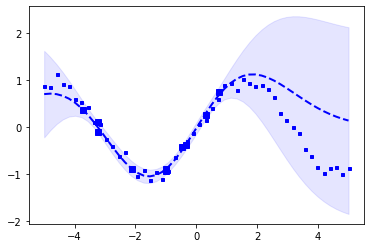

In [14]:
# test 1
y1 = YY[:,0]
Ky = K + np.eye(nX_tr) * std_y**2
invKy = np.linalg.inv(Ky)
mu1 = K_s.dot( invKy ).dot( y1 )
Cov1 = K_ss - K_s.dot( invKy ).dot( K_s.T )
std1 = np.sqrt( np.diag( Cov1 ) )
logML1 = -0.5 * y1.T.dot(invKy).dot(y1) - 0.5 * np.log( np.linalg.det( Ky ) ) - 0.5 * nX_tr * np.log( 2*np.pi ); print( logML1 )

# Plot
plt.figure()
plt.plot(XX, YY[:,0], 'bs', ms=6);
plt.plot(XX_te, YY_te[:,0], 'bs', ms=3);
plt.fill_between(x=XX_te[:,0], y1=mu1-2*std1, y2=mu1+2*std1, alpha=0.1, color='blue');
plt.plot(XX_te, mu1, 'b--', lw=2);
# plt.axis([-5, 5, -3, 3]);
# plt.title('Samples from the GP posterior along with the training ');
# # plt.show()

0.24701728895405495


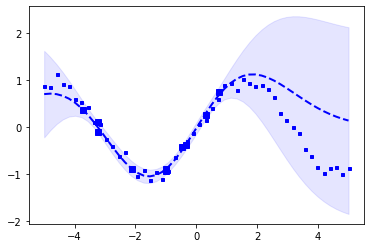

In [15]:
# test 2
Ly = np.linalg.cholesky(Ky)
alp = np.linalg.solve( Ly.T, np.linalg.solve( Ly, y1 ) )
mu2 = K_s.dot( alp )
vv = np.linalg.solve( Ly, K_s.T )
Cov2 = K_ss - vv.T.dot(vv)
std2 = std1 = np.sqrt( np.diag( Cov1 ) )
logML2 = - 0.5 * y1.T.dot( alp ) - np.sum( np.log( np.diag(Ly) ) ) - 0.5 * nX_tr * np.log(2*np.pi); print( logML2 )

# Plot
plt.figure()
plt.plot(XX, YY[:,0], 'bs', ms=6);
plt.plot(XX_te, YY_te[:,0], 'bs', ms=3);
plt.fill_between(x=XX_te[:,0], y1=mu2-2*std2, y2=mu2+2*std2, alpha=0.1, color='blue');
plt.plot(XX_te, mu2, 'b--', lw=2);
# plt.axis([-5, 5, -3, 3]);
# plt.title('Samples from the GP posterior along with the training ');
# # plt.show()

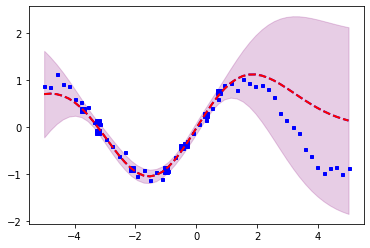

In [16]:
# Plot
plt.figure()
plt.plot(XX, YY[:,0], 'bs', ms=6);
plt.plot(XX_te, YY_te[:,0], 'bs', ms=3);
plt.fill_between(x=XX_te[:,0], y1=mu1-2*std1, y2=mu1+2*std1, alpha=0.1, color='blue');
plt.plot(XX_te, mu1, 'b--', lw=2);
plt.fill_between(x=XX_te[:,0], y1=mu2-2*std2, y2=mu2+2*std2, alpha=0.1, color='red');
plt.plot(XX_te, mu2, 'r--', lw=2);
# plt.axis([-5, 5, -3, 3]);
# plt.title('Samples from the GP posterior along with the training ');
# # plt.show()

## Multi-output case

In [17]:
# reuse the single-output quantities form above, as I consider the isotropic case here, thus the matrix-valued Gram matrices 
# can conviently be as kroneker products;
SIG_y = (std_y**2)*np.eye(2) # diagonal matrix of output scales
B = np.array([[0.35, 0.25], [0.25, 0.5]]) # output kernel (true)
KK = np.kron(B,K) # compined Gram matrix
KK_s = np.kron(B,K_s)
KK_ss = np.kron(B,K_ss)
SIG_KK = np.kron( SIG_y , np.eye(nX_tr) )
Y_c = YY.ravel('F')[:, None]

### Posterior predictive distribution

95\% Bayesian credible interval of the posterior model.

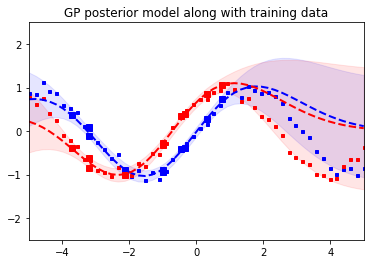

In [18]:
# Apply the kernel function to our training points
L_KKy = np.linalg.cholesky(KK + SIG_KK)
invL_KKy = np.linalg.inv(L_KKy)
invKKy = invL_KKy.T.dot(invL_KKy) # invK = invL^T invL

# predictive mean
MU_c = KK_s.dot( invKKy ).dot( Y_c )
COV_c = KK_ss - (KK_s.dot( invKKy )).dot( KK_s.T )
STD_c = np.sqrt( np.diag(COV_c) )

MU = MU_c.reshape((2,nX_te)).T
STD = STD_c.reshape((2,nX_te)).T

plt.figure()
plt.plot(XX, YY[:,0], 'bs', ms=6);
plt.plot(XX, YY[:,1], 'rs', ms=6);
plt.plot(XX_te, YY_te[:,0], 'bs', ms=3);
plt.plot(XX_te, YY_te[:,1], 'rs', ms=3);
plt.fill_between(x=XX_te[:,0], y1=MU[:,0]-2*STD[:,0], y2=MU[:,0]+2*STD[:,0], alpha=0.1, color='blue');
plt.plot(XX_te, MU[:,0], 'b--', lw=2)
plt.fill_between(x=XX_te[:,0], y1=MU[:,1]-2*STD[:,1], y2=MU[:,1]+2*STD[:,1], alpha=0.1, color='red');
plt.plot(XX_te, MU[:,1], 'r--', lw=2)
plt.axis([-5, 5, -2.5, 2.5]);
plt.title('GP posterior model along with training data');
# # plt.show()

As we have considered a zero mean function for the processes, the predictions will simply approach zero, as the distance to the training exampls gets larger, see e.g. x=5, thus this model should only be use as an interpolator or for extrapolation near the training points, as is also apparent from the plot.